# MSAS Cycling Aging: RPT Capacity vs Cycle (EFC)

This notebook plots **all cycling-aging** MSAS cells (TP_z*) using RPT check-up points.
We use `msas_efc` as the cycle-equivalent x-axis (EFC).

Notes:
- RPT-like tags are used: `ET_T23`, `CU`, `exCU`, `AT_T23`.
- Capacity is `max(discharge_capacity_in_Ah)` from each check-up curve.
- If you prefer a different x-axis, set `x_axis = 'order'` to use check-up order.


In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from batteryml.data.battery_data import BatteryData

In [ ]:
processed_dir = Path("../../data/processed/MSAS")
allowed_tags = {"ET_T23", "CU", "exCU", "AT_T23"}
x_axis = "efc"  # 'efc' or 'order'

if not processed_dir.exists():
    raise FileNotFoundError("Missing data/processed/MSAS. Run MSAS preprocessing first.")

In [ ]:
rows = []
cycling_files = [p for p in processed_dir.glob("*.pkl") if "_TP_z" in p.stem]

for path in sorted(cycling_files):
    cell = BatteryData.load(path)
    for c in (cell.cycle_data or []):
        meta = getattr(c, "additional_data", {}) or {}
        tag = meta.get("msas_tag")
        if tag not in allowed_tags:
            continue
        q = np.asarray(c.discharge_capacity_in_Ah or [], dtype=float)
        if q.size == 0:
            continue
        q_end = float(np.nanmax(q))
        if not np.isfinite(q_end):
            continue
        rows.append({
            "cell_id": cell.cell_id,
            "tag": tag,
            "efc": float(meta.get("msas_efc")) if meta.get("msas_efc") is not None else np.nan,
            "order": float(meta.get("msas_order")) if meta.get("msas_order") is not None else np.nan,
            "capacity_ah": q_end,
        })

df = pd.DataFrame(rows)
df = df.dropna(subset=[x_axis])

print("cycling cells", df["cell_id"].nunique())
print("points", len(df))
df.head()

cycling cells 147
points 2082


,cell_id,tag,efc,order,capacity_ah
0,MSAS_S1_TP_z01_01,ET_T23,0.000000,1.0,4.767439
1,MSAS_S1_TP_z01_01,CU,65.643731,3.0,4.766094
2,MSAS_S1_TP_z01_01,CU,130.986120,5.0,4.742568
3,MSAS_S1_TP_z01_01,exCU,196.274869,7.0,4.723737
4,MSAS_S1_TP_z01_01,CU,326.940309,9.0,4.691098


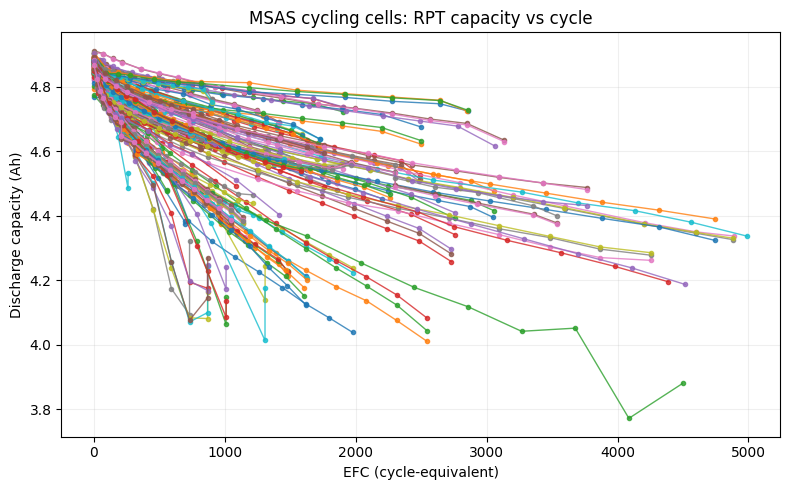

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

for cell_id, g in df.groupby("cell_id"):
    g = g.sort_values(x_axis)
    ax.plot(g[x_axis], g["capacity_ah"], '.-', alpha=0.8, linewidth=1)

x_label = "EFC (cycle-equivalent)" if x_axis == "efc" else "Check-up order"
ax.set_xlabel(x_label)
ax.set_ylabel("Discharge capacity (Ah)")
ax.set_title("MSAS cycling cells: RPT capacity vs cycle")
ax.grid(True, alpha=0.2)
plt.tight_layout()

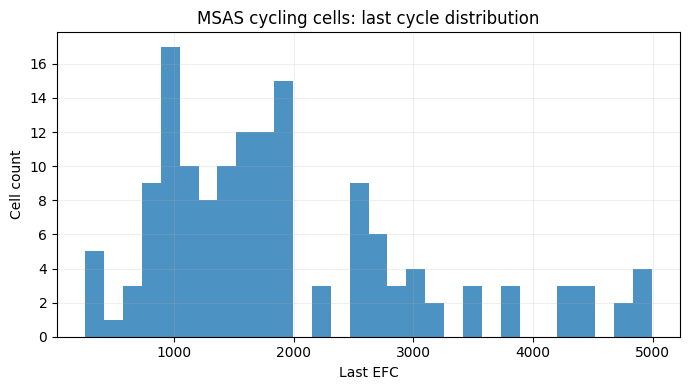

In [ ]:
# Histogram of the last available cycle (EFC/order) per cell
last_points = df.sort_values(x_axis).groupby("cell_id").tail(1)

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(last_points[x_axis], bins=30, alpha=0.8, color="#1f77b4")
x_label = "Last EFC" if x_axis == "efc" else "Last check-up order"
ax.set_xlabel(x_label)
ax.set_ylabel("Cell count")
ax.set_title("MSAS cycling cells: last cycle distribution")
ax.grid(True, alpha=0.2)
plt.tight_layout()

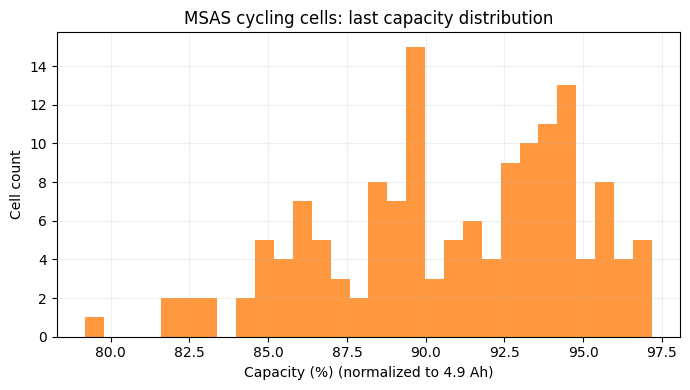

In [ ]:
# Histogram of the last available capacity per cell
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(last_points["capacity_ah"]/4.9*100, bins=30, alpha=0.8, color="#ff7f0e")
ax.set_xlabel("Capacity (%) (normalized to 4.9 Ah)")
ax.set_ylabel("Cell count")
ax.set_title("MSAS cycling cells: last capacity distribution")
ax.grid(True, alpha=0.2)
plt.tight_layout()